In [3]:
!pip install torch-scatter torch-sparse torch-geometric torch-geometric-temporal rdkit mediapipe

  Using cached torch_scatter-2.1.1.tar.gz (107 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 36.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 40.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 33.6 MB/s eta 0:00:0000:0100:01
  Created wheel for torch-scatter: filename=torch_scatter-2.1.1-cp37-cp37m-linux_x86_64.whl size=482194 sha256=023008b0d92fcf5572be3d428fe96c59a97bbe4f6e2d8f05327d5b11ca1405d2
  Stored in directory: /root/.cache/pip/wheels/d1/a7/30/10255fdd299a5650b73c802ec1e308

In [4]:
import networkx as nx
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import global_mean_pool as gmeanp, global_max_pool as gmaxp, global_add_pool
from torch_geometric.nn import (NNConv,global_mean_pool,graclus,max_pool,max_pool_x,)
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

from mediapipe.python.solutions import pose as mp_pose
import mediapipe as mp
import cv2
from threading import Thread

In [5]:
def feed_forward(input_dim, hidden_dim, output_dim, num_hidden_layers, activation=nn.ReLU):
    dims = [input_dim] + [hidden_dim] * num_hidden_layers
    layers = []
    for i in range(num_hidden_layers):
        layers.append(nn.Linear(dims[i], dims[i + 1]))
        layers.append(activation())
    layers.append(nn.Linear(hidden_dim, output_dim))
    return nn.Sequential(*layers)

def convert_2_node(all_graph):
    shape_0 = all_graph.shape[0]
    meo = torch.reshape(all_graph,(shape_0,12,3))
    return meo
def get_feature_node(all_graph): #all_graph.shape = 32, 24, 3 - 32 đồ thị, 24 đỉnh, 3 đặc trưng mỗi đỉnh
    all_node_feature = []
    num_nodes = all_graph.shape[1]
    num_graph = all_graph.shape[0]
    for graph in range(num_graph):
        all_node_feature.append([])
        for node in range(num_nodes):
            x = all_graph[graph][node][0]
            y = all_graph[graph][node][1]
            z = all_graph[graph][node][2]
            mau_so = torch.sqrt( x**2 + y**2 + z**2 )
            x_axis = torch.acos(x / mau_so)
            y_axis = torch.acos(y / mau_so)
            z_axis = torch.acos(z / mau_so)
            all_node_feature[graph].append([x, y, z, x_axis, y_axis, z_axis])
    return torch.Tensor(all_node_feature)

def reshape_node(sub):
    # x =  batch, time, số đỉnh, số đặc trưng
    # reshape lại theo đỉnh = batch, số đỉnh, số đặc trung, time
    shape0_sub = sub.shape[0]
    shape1_sub = sub.shape[1]
    shape2_sub = sub.shape[2]
    shape3_sub = sub.shape[3]
    edge_sub = []
    for x in range(shape0_sub): # Batch
        edge_index = []
        for y in range(shape2_sub): # Số đỉnh
            edge_index.append([])
            for z in range(shape3_sub): # Số đặc trưng
                edge_index[y].append([])
                for t in range(shape1_sub):
                    ff = sub[x][t][y][z]
                    edge_index[y][z].append(ff.item())
        edge_sub.append(edge_index)
    return edge_sub

def get_data_series(data, time):
#     print(data)
    shape_0 = data.shape[0] + 1
    new_arr = []
    for i in range(time, shape_0):
        new_arr.append(data[i-time:i].tolist())
    new_arr = torch.Tensor(new_arr)
    return new_arr

In [38]:
# violent_0_100 = pd.read_csv("/kaggle/input/csvrwf/fight_0_100.csv")
# violent_100_200 = pd.read_csv("/kaggle/input/csvrwf/fight_100_200.csv")
# violent_200_300 = pd.read_csv("/kaggle/input/csvrwf/fight_200_300.csv")
# violent_300_400 = pd.read_csv("/kaggle/input/csvrwf/fight_300_400.csv")
# violent_400_500 = pd.read_csv("/kaggle/input/csvrwf/fight_400_500.csv")
# violent_500_600 = pd.read_csv("/kaggle/input/csvrwf/fight_500_600.csv")
# violent_600_700 = pd.read_csv("/kaggle/input/csvrwf/fight_600_700.csv")
# violent_700_800 = pd.read_csv("/kaggle/input/csvrwf/fight_700_800.csv")
# violent_800_900 = pd.read_csv("/kaggle/input/csvrwf/fight_800_900.csv")
# violent_900_1000 = pd.read_csv("/kaggle/input/csvrwf/fight_900_1000.csv")

# violent_0_100 = pd.read_csv("/kaggle/input/csvrwf/violent_hockey_0_200.csv")
# violent_100_200 = pd.read_csv("/kaggle/input/csvrwf/violent_hockey_200_400.csv")
# violent_200_300 = pd.read_csv("/kaggle/input/csvrwf/violent_hockey_400_500.csv")

# normal_0_100 = pd.read_csv("/kaggle/input/csvrwf/nonfight_0_100.csv")
# normal_100_200 = pd.read_csv("/kaggle/input/csvrwf/nonfight_100_200.csv")
# normal_200_300 = pd.read_csv("/kaggle/input/csvrwf/nonfight_200_300.csv")
# normal_300_400 = pd.read_csv("/kaggle/input/csvrwf/nonfight_300_400.csv")
# normal_400_500 = pd.read_csv("/kaggle/input/csvrwf/nonfight_400_500.csv")
# normal_500_600 = pd.read_csv("/kaggle/input/csvrwf/nonfight_500_600.csv")
# normal_600_700 = pd.read_csv("/kaggle/input/csvrwf/nonfight_600_700.csv")
# normal_700_800 = pd.read_csv("/kaggle/input/csvrwf/nonfight_700_800.csv")
# normal_800_900 = pd.read_csv("/kaggle/input/csvrwf/nonfight_800_900.csv")
# normal_900_1000 = pd.read_csv("/kaggle/input/csvrwf/nonfight_900_1000.csv")


# normal_0_100 = pd.read_csv("/kaggle/input/csvrwf/nonviolent_hockey_0_200.csv")
# normal_100_200 = pd.read_csv("/kaggle/input/csvrwf/nonviolent_hockey_200_400.csv")
# normal_200_300 = pd.read_csv("/kaggle/input/csvrwf/nonviolent_hockey_400_500.csv")
normal_0_100 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-movie/nonfight.csv")
# normal_100_200 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/nonviolent_hockey_200_400.csv")
# normal_200_300 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/nonviolent_hockey_400_500.csv")

violent_0_100 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-movie/fight.csv")
# violent_100_200 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/violent_hockey_200_400.csv")
# violent_200_300 = pd.read_csv("/kaggle/input/skeleton-clone-dataset-hockey/violent_hockey_400_500.csv")

# violent_0_100 = violent_0_100.append(violent_100_200)
# violent_0_100 = violent_0_100.append(violent_200_300)
# violent_0_100 = violent_0_100.append(violent_300_400)
# violent_0_100 = violent_0_100.append(violent_400_500)
# violent_0_100 = violent_0_100.append(violent_500_600)
# violent_0_100 = violent_0_100.append(violent_600_700)
# violent_0_100 = violent_0_100.append(violent_700_800)
# violent_0_100 = violent_0_100.append(violent_800_900)
# violent_0_100 = violent_0_100.append(violent_900_1000)

# normal_0_100 = normal_0_100.append(normal_100_200)
# normal_0_100 = normal_0_100.append(normal_200_300)
# normal_0_100 = normal_0_100.append(normal_300_400)
# normal_0_100 = normal_0_100.append(normal_400_500)
# normal_0_100 = normal_0_100.append(normal_500_600)
# normal_0_100 = normal_0_100.append(normal_600_700)
# normal_0_100 = normal_0_100.append(normal_700_800)
# normal_0_100 = normal_0_100.append(normal_800_900)
# normal_0_100 = normal_0_100.append(normal_900_1000)

In [39]:
feature_violent = violent_0_100.iloc[:,1:].values
feature_violent = torch.from_numpy(feature_violent)
print(f"Hockey fight: {feature_violent.shape}")

feature_non_violent = normal_0_100.iloc[:,1:].values
feature_non_violent = torch.from_numpy(feature_non_violent)
print(f"hockey non fight: {feature_non_violent.shape}")

Hockey fight: torch.Size([299, 36])
hockey non fight: torch.Size([510, 36])


In [40]:
time = 10

shape_0_violent = feature_violent.shape[0]
feature_violent = torch.reshape(feature_violent, (shape_0_violent,12,3))
feature_time_violent = get_data_series(feature_violent, time)
label_time_violent = torch.ones(feature_time_violent.shape[0])
print(feature_time_violent.shape)

shape_0_non_violent = feature_non_violent.shape[0]
feature_non_violent = torch.reshape(feature_non_violent, (shape_0_non_violent,12,3))
feature_time_non_violent = get_data_series(feature_non_violent, time)
label_time_non_violent = torch.zeros(feature_time_non_violent.shape[0])
print(feature_time_non_violent.shape)

torch.Size([290, 10, 12, 3])
torch.Size([501, 10, 12, 3])


In [41]:
feature_time = torch.concat((feature_time_violent, feature_time_non_violent), 0)
feature_time = feature_time.numpy()

label_time = torch.concat((label_time_violent, label_time_non_violent), 0)
label_time = to_categorical(label_time)

x_train_time_all, x_test_time, y_train_time_all, y_test_time = train_test_split(feature_time, label_time, test_size=0.2)
x_train_time, x_val_time, y_train_time, y_val_time = train_test_split(x_train_time_all, y_train_time_all, test_size=0.25)

x_train_time = torch.from_numpy(x_train_time)
x_test_time = torch.from_numpy(x_test_time)
x_val_time = torch.from_numpy(x_val_time)

y_train_time = torch.from_numpy(y_train_time)
y_test_time = torch.from_numpy(y_test_time)
y_val_time = torch.from_numpy(y_val_time)


train_data_time = torch.utils.data.TensorDataset(x_train_time, y_train_time)
train_iter_time = torch.utils.data.DataLoader(train_data_time, batch_size = 128, shuffle=True)

test_data_time = torch.utils.data.TensorDataset(x_test_time, y_test_time)
test_iter_time = torch.utils.data.DataLoader(test_data_time, batch_size = 128, shuffle=True)

val_data_time = torch.utils.data.TensorDataset(x_val_time, y_val_time)
val_iter_time = torch.utils.data.DataLoader(val_data_time, batch_size = 128, shuffle=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu") # cuda
edge_index = torch.Tensor([
    [ 4,  2,  2,  0,  0,  0,  1,  1,  1,  3,  3,  5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 10, 9],
    [ 2,  4,  0,  2,  1, 6,  0, 7,  3,  1,  5,  3,  0, 7, 8,  1, 6, 9, 6, 10, 7, 11, 8, 11]
]).long().to(device=device)

In [7]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        self.tgnn = A3TGCN2(in_channels = node_features,  out_channels = 32, periods=periods,batch_size=batch_size) 
        self.linear_1 = nn.Linear(32,16)
        self.linear_2 = nn.Linear(16,8)
        self.linear_3 = feed_forward(8, 4, 2, 1)
        self.flatten = nn.Flatten()
        self.sm = nn.Softmax(dim = 1)
    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x, edge_index, edge_weight) # x [b, 207, 2, 12]  returns h [b, 207, 12]
#         print(h.shape)
#         print(f"h_shape: {h.shape}")
        h = F.relu(h)
        zeros = torch.zeros(h.shape[1]).long().to(device=x.device) # h.shape[1] = num nodes in graph
        h = global_add_pool(h, zeros)
        h = self.linear_1(h)
        h = F.relu(h)
        h = self.linear_2(h)
        h = F.relu(h)
        h = self.linear_3(h)
        h = self.flatten(h)
        h = self.sm(h)
        return h

model_3 = TemporalGNN(node_features = 6, periods = 10, batch_size = 128)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
model_3.to(device)
# print(model_3)
# for name, param in model_3.named_parameters():
#     print(f"{name}: {param}")
#     print("=================================================")

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(6, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(6, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(6, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (linear_2): Linear(in_features=16, out_features=8, bias=True)
  (linear_3): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sm): Softmax(dim=1)
)

In [8]:
link = r"/kaggle/input/research-graph-model/model_a3tgcn_movie.pth"
model_3.load_state_dict(torch.load(link))
model_3.eval()

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(6, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(6, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(6, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (linear_2): Linear(in_features=16, out_features=8, bias=True)
  (linear_3): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sm): Softmax(dim=1)
)

In [9]:
# ga = np.random.rand(1,10,36)

def reference_node(data):
    data = torch.from_numpy(data)
    data = data.squeeze(0)
    data = convert_2_node(data)
    return data.unsqueeze(0)


# feature_time = torch.rand(1, 10, 12, 3).float()
def inference(feature_time,model_3):
    new_x = []
    for index in feature_time:
        new_x.append(get_feature_node(index).tolist())
    new_x = torch.Tensor(new_x).to(device=device)
    new_x = torch.Tensor(reshape_node(new_x)).to(device=device)
    edge_weight = torch.ones(edge_index.shape[1]).to(device=device) 
    pred = model_3(new_x, edge_index, edge_weight)
    return pred

In [10]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

/opt/conda/lib/python3.7/site-packages/torch/hub.py:268: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-4-25 Python-3.7.12 torch-1.13.0+cpu CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


  0%|          | 0.00/3.87M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [22]:
label = "???????"
n_time_steps = 10
lm_list = []
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

mp_drawing = mp.solutions.drawing_utils
mp_pose =mp.solutions.pose
violent_n = 0
non_vilent_n = 0
def draw_class_on_image(label, img):
    global violent_n
    global non_vilent_n
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    fontScale = 1
    fontColor = (255, 0, 0)
    thickness = 2
    lineType = 2
    cv2.putText(img, label,
                (200, 60),
                font,
                fontScale,
                (0, 255, 0),
                thickness,
                lineType)

    bottomLeftCornerOfText = (200, 100)
    cv2.putText(img, "Non violence",
                bottomLeftCornerOfText,
                font,
                fontScale,
                fontColor,
                thickness,
                lineType)

    cv2.putText(img, f"{non_vilent_n}",
                (500, 100),
                font,
                fontScale,
                fontColor,
                thickness,
                lineType)


    bottomLeftCornerOfText_2 = (200, 150)
    fontColor_2 = (0, 0, 255)
    cv2.putText(img, "Violence: ",
                bottomLeftCornerOfText_2,
                font,
                fontScale,
                fontColor_2,
                thickness,
                lineType)

    cv2.putText(img, f"{violent_n}",
                (500, 150),
                font,
                fontScale,
                fontColor_2,
                thickness,
                lineType)

    return img

def detect(model, lm_list):
    global violent_n
    global non_vilent_n

    global label
    data = pd.DataFrame(lm_list)
    data = np.nan_to_num(data)
    data = pd.DataFrame(data)
    X_data = data.iloc[:, :].values
    len_X_data = len(X_data)
    

    X = []
    for i in range(10, len_X_data):
        X.append(X_data[i-10:i, :])
    X = np.array(X)
    print(f"X.shape: {X.shape}") # 1 - 10 - 36
    X = reference_node(X)
    print(f"X.shape: {X.shape}") # 1 - 10 - 12-3

#     results = model.predict(X)
#     results = model(X)
    results = inference(X,model)
    print(f"Result: {results.shape}")
    print(f"Result: {results[0][0].item()}")
    print(f"Result: {results[0][1].item()}")


    if results[0][0] < 0.5:
        label = "Violent"
        violent_n = violent_n + 1
    else:
        label = "Non-Violent"
        non_vilent_n = non_vilent_n + 1
    print(label)
    return label
video_path =r"/kaggle/input/skeleton-clone-dataset-movie/drive-download-20230321T021922Z-001/fights/newfi10.avi"

fourcc = cv2.VideoWriter_fourcc(*'XVID')

output = cv2.VideoWriter(r"ga3.avi", fourcc, 30.0, (720, 576))


cap = cv2.VideoCapture(video_path)
skipTime  = 0
skipFrame = 0
X = []
while True:    
    ret, frame = cap.read()
    
#     print(f"frame: {frame.shape}")

    if not ret:
        break
#     if  1  == 1: # Đừng quan tâm dòng này nha, dòng này không có ý nghĩa
    result = yolo_model(frame)     # Detect person
    for (xmin, ymin, xmax,   ymax,  confidence,  clas) in result.xyxy[0].tolist(): # [ 1,2,3,4,5]
        c_lm = []
        with mp_pose.Pose(min_detection_confidence=0.1, min_tracking_confidence=0.1) as pose:
            resulta = pose.process(frame[int(ymin):int(ymax),int(xmin):int(xmax):])
            if resulta.pose_landmarks and clas ==0:
                mp_drawing.draw_landmarks(frame[int(ymin):int(ymax),int(xmin):int(xmax):], resulta.pose_landmarks, mp_pose.POSE_CONNECTIONS) 
                for (id, lm) in enumerate(resulta.pose_landmarks.landmark):
                    if id > 10 and id not in [17,18,19,20,21,22] and id not in [29,30,31,32] :
                        c_lm.append(lm.x)
                        c_lm.append(lm.y)
                        c_lm.append(lm.z)
#                         c_lm.append(lm.visibility)
                if  len(c_lm) > 0:
                    X.append(c_lm) # khi đã có dữ liệu c_lm thì thêm vào X
                if len(X) >= 11: # X >= 10 bới vì trong file train của mình, ở chỗ lưu lại file csv, thì lúc dó mình đã lấy 10 hàng chuyển hành cột 
                    print("==========")
                    t1 = Thread(target=detect,args=(model_3,X,)) # ở đây ta sẽ tiến hành predict, hàm Thread là ta chạy ở 1 luồng khác, tức là 
                    t1.start()

                    X = [] # Khi dữ liệu đã có thì ta lại khởi tạo lại từ đầu, ví dụ như, 
    frame = draw_class_on_image(label, frame)
    output.write(frame)
#     if cv2.waitKey(0) & 0xFF == ord('q'):
#            break
cap.release()
output.release()
# cv2.destroyAllWindows()

frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
X.shape: (1, 10, 36)
X.shape: torch.Size([1, 10, 12, 3])
Result: torch.Size([1, 2])
Result: 0.0582585446536541
Result: 0.9417414665222168
Violent
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
X.shape: (1, 10, 36)
X.shape: torch.Size([1, 10, 12, 3])
Result: torch.Size([1, 2])
Result: 1.0653792742232326e-05
Result: 0.99998939037323
Violent
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
X.shape: (1, 10, 36)
X.shape: torch.Size([1, 10, 12, 3])
frame: (576, 720, 3)
Result: torch.Size([1, 2])
Result: 2.778288944682572e-06
Result: 0.9999972581863403
Violent
frame: (576, 720, 3)
frame: (576, 720, 3)
frame: (576, 720, 3)
X.shape: (1, 10, 36)
X.shape: torch.Size([1, 10, 12, 3])
frame: (576, 720, 3)
Result: torch.Size([1, 2])
Result: 0.002279012929648161
Result: 0.9977210164070129
Violent
frame: (57

AttributeError: 'NoneType' object has no attribute 'shape'

In [49]:
epochs_time_3 = []

epochs_loss_3 = []
epochs_acc_3_accuracy = []
epochs_acc_3_precision = []
epochs_acc_3_recall = []
epochs_acc_3_f1 = []

epochs_test_loss_3 = []
epochs_test_acc_3_accuracy = []
epochs_test_acc_3_precision = []
epochs_test_acc_3_recall = []
epochs_test_acc_3_f1 = []


for i in range(5):
    loss_list, test_loss_list = [], []

    acc_f1, test_acc_f1 = [], []
    acc_accuracy, test_acc_accuracy = [], []
    acc_precision, test_acc_precision = [], []
    acc_recall, test_acc_recall = [], []

    model_3.train()
    for x,y in train_iter_time:
        print(x.shape)
#         break
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad() 
        new_x = []
        for index in x:
            new_x.append(get_feature_node(index).tolist())
        new_x = torch.Tensor(new_x).to(device=device)
        new_x = torch.Tensor(reshape_node(new_x)).to(device=device)
        edge_weight = torch.ones(edge_index.shape[1]).to(device=device) 
        print(new_x.shape)
        # Graph temporal
        pred = model_3(new_x, edge_index, edge_weight)
        break
        loss = loss_fn(pred, y)
        loss_list.append(loss.item())

        ground_truth = torch.argmax(y, dim=1).cpu().detach().numpy()
        pred_ind = torch.argmax(pred, dim=1).cpu().detach().numpy()
    
        accuracy = accuracy_score(ground_truth, pred_ind)
        acc_accuracy.append(accuracy)
        
        precision = precision_score(ground_truth, pred_ind, average= "binary")
        acc_precision.append(precision)
        
        recall = recall_score(ground_truth, pred_ind,  average='binary')
        acc_recall.append(recall)
        
        f1 = f1_score(ground_truth, pred_ind, average="binary")
        acc_f1.append(f1)
        
        loss.backward()
        optimizer.step()
    break
    model_3.eval()
    for x_test,y_test in test_iter_time:

        x_test = x_test.to(device)
        y_test = y_test.to(device)
        new_x = []
        for index in x_test:
            new_x.append(get_feature_node(index).tolist())
        new_x = torch.Tensor(new_x).to(device=device)
        new_x = torch.Tensor(reshape_node(new_x)).to(device=device)
        edge_weight = torch.ones(edge_index.shape[1]).to(device=device) 

        pred_test = model_3(new_x, edge_index, edge_weight)

        loss_test = loss_fn(pred_test, y_test)
        test_loss_list.append(loss_test.item())
        
        ground_truth_test = torch.argmax(y_test, dim=1).cpu().detach().numpy()
        pred_ind_test = torch.argmax(pred_test, dim=1).cpu().detach().numpy()
        
        test_accuracy = accuracy_score(ground_truth_test, pred_ind_test)
        test_acc_accuracy.append(test_accuracy)
        
        test_precision = precision_score(ground_truth_test, pred_ind_test, average= "binary")
        test_acc_precision.append(test_precision)
        
        test_recall = recall_score(ground_truth_test, pred_ind_test,  average='binary')
        test_acc_recall.append(test_recall)
    
        test_f1 = f1_score(ground_truth_test, pred_ind_test, average="binary")
        test_acc_f1.append(test_f1)

    epochs_time_3.append(i)
    total_loss = sum(loss_list)/len(loss_list)
    test_total_loss = sum(test_loss_list)/len(test_loss_list)
    epochs_loss_3.append(total_loss)
    epochs_test_loss_3.append(test_total_loss)
    
    total_accuracy = sum(acc_accuracy)/len(acc_accuracy)
    test_total_accuracy = sum(test_acc_accuracy)/len(test_acc_accuracy)
    epochs_acc_3_accuracy.append(total_accuracy)
    epochs_test_acc_3_accuracy.append(test_total_accuracy)

    total_precision = sum(acc_precision)/len(acc_precision)
    test_total_precision = sum(test_acc_precision)/len(test_acc_precision)
    epochs_acc_3_precision.append(total_precision)
    epochs_test_acc_3_precision.append(test_total_precision)
    
    total_recall = sum(acc_recall)/len(acc_recall)
    test_total_recall = sum(test_acc_recall)/len(test_acc_recall)
    epochs_acc_3_recall.append(total_recall)
    epochs_test_acc_3_recall.append(test_total_recall)
    
    total_f1 = sum(acc_f1)/len(acc_f1)
    test_total_f1 = sum(test_acc_f1) / len(test_acc_f1)
    epochs_acc_3_f1.append(total_f1)
    epochs_test_acc_3_f1.append(test_total_f1)

    print(f"Epochs: {i}, loss: {total_loss}, test loss: {test_total_loss}")
    print(f"Accuracy acc: {total_accuracy}, test accuracy acc: {test_total_accuracy}")
    print(f"Accuracy precision: {total_precision}, test accuracy precision: {test_total_precision}")
    print(f"Accuracy recall: {total_recall}, test accuracy recall: {test_total_recall}")
    print(f"Accuracy f1: {total_f1}, test accuracy f1: {test_total_f1}")
    print(f"=======================================================================")

torch.Size([128, 10, 12, 3])
torch.Size([128, 12, 6, 10])


In [3]:
# for name, param in model_3.named_parameters():
#     print(f"{name}: {param}")
#     print("=================================================")

Loss val: 0.4072805941104889
Accuracy acc val: 0.9043026364306784
Accuracy precision val: 0.9261277431769529
Accuracy recall val: 0.9154253591129818
Accuracy f1 val: 0.9202046757803696


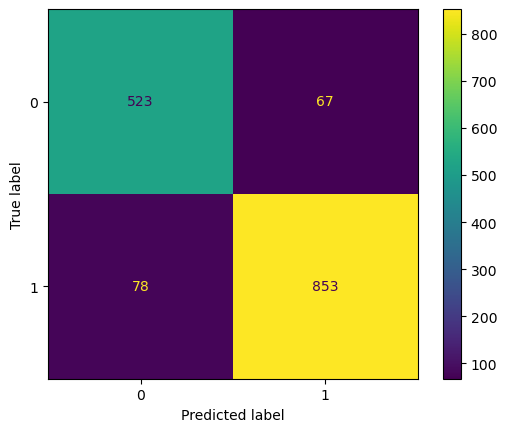

In [11]:
model_3.eval()
val_loss_list = []
val_acc_accuracy = []
val_acc_precision = []
val_acc_recall = []
val_acc_f1 = []

# Thêm confusion
pred_list = []
ground_truth_list = []

for x_val,y_val in val_iter_time:
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        new_x = []
        
        for index in x_val:
            new_x.append(get_feature_node(index).tolist())
        new_x = torch.Tensor(new_x).to(device=device)
        new_x = torch.Tensor(reshape_node(new_x)).to(device=device)
        edge_weight = torch.ones(edge_index.shape[1]).to(device=device) 

        pred_val = model_3(new_x, edge_index, edge_weight)
        loss_val = loss_fn(pred_test, y_test)
        val_loss_list.append(loss_val.item())

        pred_ind_val = torch.argmax(pred_val, dim=1).cpu().detach().numpy()
        ground_truth_val = torch.argmax(y_val, dim=1).cpu().detach().numpy()
        
        # Thêm confusion
        pred_list.append(torch.argmax(pred_val, dim=1))
        ground_truth_list.append(torch.argmax(y_val, dim=1))
        
        val_accuracy = accuracy_score(ground_truth_val, pred_ind_val)
        val_acc_accuracy.append(val_accuracy)
        
        val_precision = precision_score(ground_truth_val, pred_ind_val, average= "binary")
        val_acc_precision.append(val_precision)
        
        val_recall = recall_score(ground_truth_val, pred_ind_val,  average='binary')
        val_acc_recall.append(val_recall)
    
        val_f1 = f1_score(ground_truth_val, pred_ind_val, average="binary")
        val_acc_f1.append(val_f1)

val_total_loss = sum(val_loss_list)/len(val_loss_list)
val_total_accuracy = sum(val_acc_accuracy)/len(val_acc_accuracy)
val_total_precision = sum(val_acc_precision)/len(val_acc_precision)
val_total_recall = sum(val_acc_recall)/len(val_acc_recall)
val_total_f1 = sum(val_acc_f1) / len(val_acc_f1)

print(f"Loss val: {val_total_loss}")
print(f"Accuracy acc val: {val_total_accuracy}")
print(f"Accuracy precision val: {val_total_precision}")
print(f"Accuracy recall val: {val_total_recall}")
print(f"Accuracy f1 val: {val_total_f1}")
print(f"=======================================================================")

pred_list = torch.cat(pred_list)
ground_truth_list = torch.cat(ground_truth_list)
confusion_matrix = metrics.confusion_matrix(ground_truth_list, pred_list)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

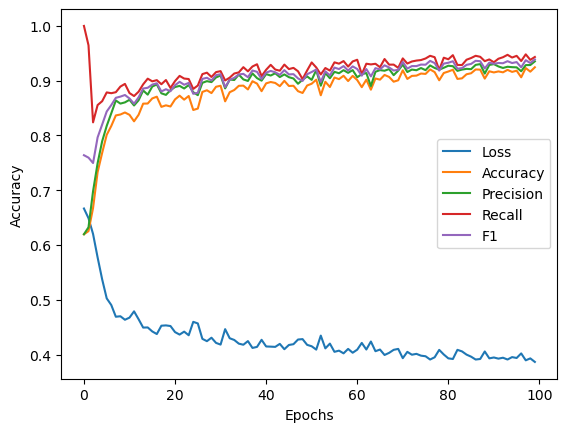

In [39]:
plt.plot(epochs_time_3, epochs_loss_3, label="Loss")
plt.plot(epochs_time_3, epochs_acc_3_accuracy, label="Accuracy")
plt.plot(epochs_time_3, epochs_acc_3_precision, label="Precision")
plt.plot(epochs_time_3, epochs_acc_3_recall, label="Recall")
plt.plot(epochs_time_3, epochs_acc_3_f1, label="F1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

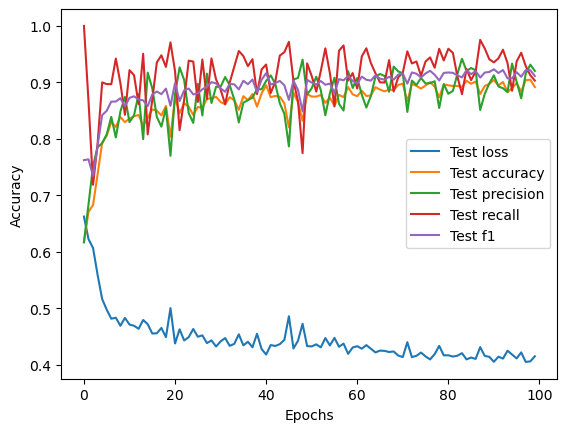

In [40]:
plt.plot(epochs_time_3, epochs_test_loss_3, label="Test loss")
plt.plot(epochs_time_3, epochs_test_acc_3_accuracy, label="Test accuracy")
plt.plot(epochs_time_3, epochs_test_acc_3_precision, label="Test precision")
plt.plot(epochs_time_3, epochs_test_acc_3_recall, label="Test recall")
plt.plot(epochs_time_3, epochs_test_acc_3_f1, label="Test f1")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [17]:
data_3 = {
    "loss": epochs_loss_3,
    "accuracy_acc": epochs_acc_3_accuracy,
    "accuracy_precision":epochs_acc_3_precision,
    "accuracy_recall": epochs_acc_3_recall,
    "accuracy_f1": epochs_acc_3_f1,
    
    "test_loss": epochs_test_loss_3,
    "test_accuracy_acc":epochs_test_acc_3_accuracy,
    "test_accuracy_precision":epochs_test_acc_3_precision,
    "test_accuracy_recall":epochs_test_acc_3_recall,
    "test_accuracy_f1":epochs_test_acc_3_f1
}
ga_3 = pd.DataFrame(data_3)
ga_3.to_csv("a3tgcn_hockey.csv")
torch.save(model_3.state_dict(), 'model_a3tgcn_hockey.pth')
print("ok")

ok


In [43]:
data_3 = {
    "loss": epochs_loss_3,
    "accuracy_acc": epochs_acc_3_accuracy,
    "accuracy_precision":epochs_acc_3_precision,
    "accuracy_recall": epochs_acc_3_recall,
    "accuracy_f1": epochs_acc_3_f1,
    
    "test_loss": epochs_test_loss_3,
    "test_accuracy_acc":epochs_test_acc_3_accuracy,
    "test_accuracy_precision":epochs_test_acc_3_precision,
    "test_accuracy_recall":epochs_test_acc_3_recall,
    "test_accuracy_f1":epochs_test_acc_3_f1
}
ga_3 = pd.DataFrame(data_3)
ga_3.to_csv("a3tgcn_hockey3.csv")
torch.save(model_3.state_dict(), 'model_a3tgcn_hockey3.pth')
print("ok")

ok


In [19]:
data_3 = {
    "loss": [1],
#     "accuracy_acc": epochs_acc_3_accuracy,
#     "accuracy_precision":epochs_acc_3_precision,
#     "accuracy_recall": epochs_acc_3_recall,
#     "accuracy_f1": epochs_acc_3_f1,
    
#     "test_loss": epochs_test_loss_3,
#     "test_accuracy_acc":epochs_test_acc_3_accuracy,
#     "test_accuracy_precision":epochs_test_acc_3_precision,
#     "test_accuracy_recall":epochs_test_acc_3_recall,
#     "test_accuracy_f1":epochs_test_acc_3_f1
}
ga_3 = pd.DataFrame(data_3)
ga_3.to_csv("a3tgcn_hock222ey.csv")
# torch.save(model_3.state_dict(), 'model_a3tgcn_hockey.pth')
# print("ok")

In [ ]:
# Sample Time
# feature_time = torch.rand(150, 10, 12, 3).float()
# label_time = torch.randint(0,2 ,(150, 1))
# label_time = to_categorical(label_time)
# label_time = torch.from_numpy(label_time)
# train_data_time = torch.utils.data.TensorDataset(feature_time, label_time)
# train_iter_time = torch.utils.data.DataLoader(train_data_time, batch_size = 128, shuffle=True)
# test_iter_time = torch.utils.data.DataLoader(train_data_time, batch_size = 128, shuffle=True)
# val_iter_time = torch.utils.data.DataLoader(train_data_time, batch_size = 128, shuffle=True)